In [1]:
# Necessary imports
from neat.node import Node, NodeType
from neat.connection import Connection
from neat.genome import Genome
from neat.species import SpeciesSet
from neat.network import FeedForwardNetwork
from neat.util import Util
import numpy as np

## Topology Encoding
A Genome is in the most simple form a DAG (Directed Acyclic Graph), which contains a list of nodes and connections.

In [16]:
# Create a new node
node1 = Node(1, NodeType.SENSOR)  # input nodes (in principle they do not need a bias)
node2 = Node(2, NodeType.OUTPUT)  # output nodes
node3 = Node(3, NodeType.HIDDEN)  # hidden nodes
print(node1)
print(node2)
print(node3)

Node 1
Sensor
Bias: -1.231311021780312

Node 2
Output
Bias: 0.4847787382432929

Node 3
Hidden
Bias: -0.32581120787351286



In [17]:
# Create a new connection
connect = Connection(0, 1)  # directed connection from Node 0 -> Node 1
print(connect)

In: 0
Out: 1
Weight: -0.2816916305922322
Enabled: True



Parent1:
===== Nodes: =====
Node 0
Sensor
Bias: 0.5318000254262314
Node 1
Sensor
Bias: 0.5332547955940331
Node 2
Sensor
Bias: 0.6105520087692028
Node 3
Output
Bias: -0.199152811007532
===== Connections: =====
In: 0
Out: 3
Weight: -1.1909918042083882
Enabled: True
In: 1
Out: 3
Weight: 0.2954370476091774
Enabled: True
In: 2
Out: 3
Weight: -0.3394296928048568
Enabled: True



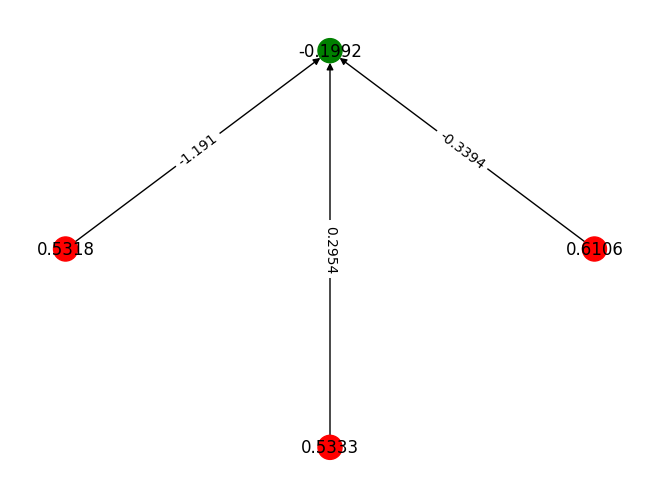

In [18]:
# Create a new genome
genome = Genome(id=0, n_inputs=3, n_outputs=1)
genome.visualize(with_bias=True, with_weights=True, with_colors=True)
print("Parent1:")
print(genome)

## Topology Decoding
For decoding a genome (DAG), first we need to know the layers (layer determination), then we can create an order of calculation.

In [19]:
# Create a NN from the created genome
model = FeedForwardNetwork.create(genome)
model.forward(np.array([[0.5, 0.6, 0.7], [0.8, 0.9, 1.0]]))  # inputs of batch sizes are also possible

array([[0.29838771],
       [0.22697305]])

## Mutation
NEAT has two topology mutations ("Add new node", "Add new connection") and two normal mutations ("Change weight", "Change bias").

Parent1 (after 5x mutation):


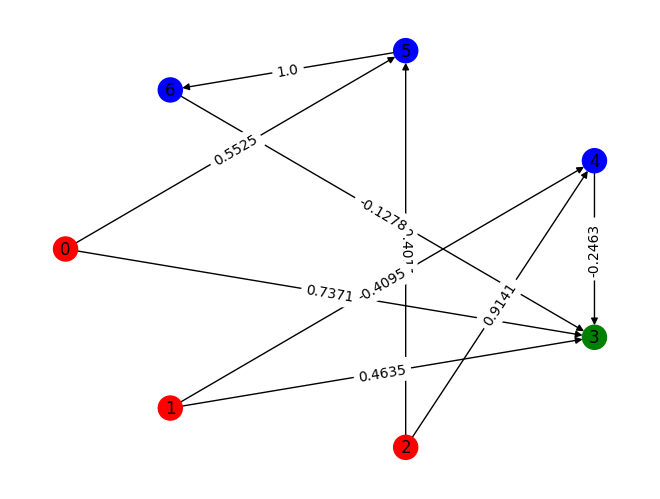

In [20]:
# Mutate a genome 5 times
genome1 = Genome(id=0, n_inputs=3, n_outputs=1)
for _ in range(5):
    genome1.mutate()
genome1.visualize(with_bias=False, with_weights=True, with_colors=True)
print("Parent1 (after 5x mutation):")

## Crossover
In NEAT the crossover operation compares the genes between two genomes. 
If two genes has the same id, we randomly choose which gene we take for the child.
If two genes has not the same id, we pick the gene from the more fitted parent.

Parent2 (after 5x mutation):


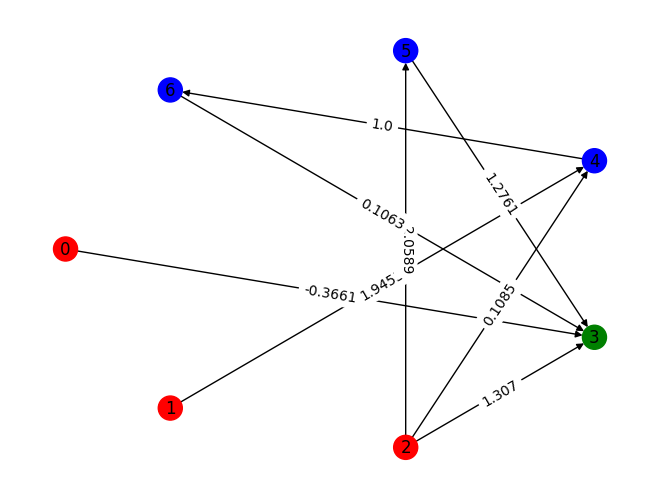

In [21]:
# Create a new genome and mutate it 5 times
genome2 = Genome(id=1, n_inputs=3, n_outputs=1)
for i in range(5):
    genome2.mutate()
genome2.visualize(with_bias=False, with_weights=True, with_colors=True)
print("Parent2 (after 5x mutation):")

Child:


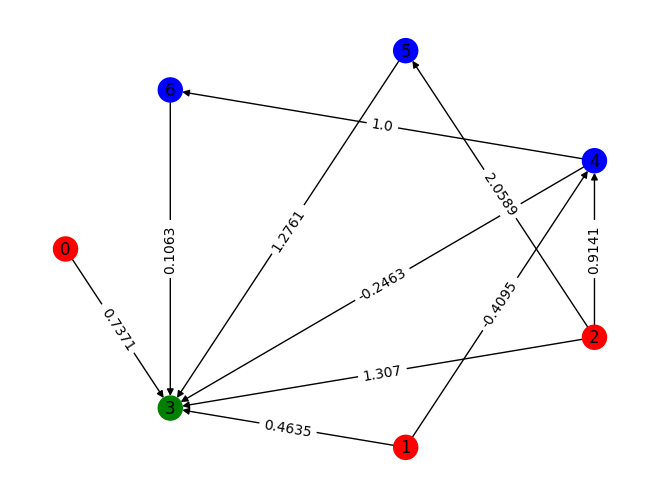

In [22]:
# Crossover genome1 and genome2
child = Genome(id=2, n_inputs=0, n_outputs=0)
child.crossover(genome1, genome2)
child.visualize(with_bias=False, with_weights=True, with_colors=True)
print("Child:")

## Speciation
In NEAT each genome of the population is categorized in Species, where similar topologies are in the same species and different topologies are in different species. This is one of the components to ensure, that newly created (untrained) topologies can be selected even if they perform bad.
For the speciation we need a distance function to measure the distance between two genomes. NEAT provides the following formula for that:
\begin{equation}
\delta(genom1, genom2) = \frac{c_1 * E}{N} + \frac{c_2 * D}{N} + c_3 * W,
\end{equation}
where
- $c_1$: weight of $E$
- $E$: number of extended genes
- $c_2$: weight of $D$
- $D$: number of disjoint genes
- $c_3$: weight of $W$
- $W$: weight difference (for same genes)

We say that $genom1$ belongs to the specie $j$ if the distance between $genom1$ and the random chosen representative $genom2$ is lower than a given threshold $\delta_t$:
\begin{equation}
\delta(genom1, genom2) < \delta_t
\end{equation}


In [23]:
# Calculate the distance between genome1 and genome2
distance = genome1.distance(genome2)
print(distance)

2.098173665235783


In [48]:
# Place a population into species
# Define a SpeciesSet
species = SpeciesSet(compatibility_threshold=3.0)  # threshold to decide if a genome is in the species or not

# Create a population of 10 genomes
population = [Genome(i, n_inputs=3, n_outputs=1) for i in range(10)]

# Perform 30 mutations
for genome in population:
    for _ in range(30):
        genome.mutate()

# Divide the population into species
species.speciate(population, generation=0)
print(species)
for specie in species.species:
    print(specie)

===== Species: =====
Species(id=0, representative_id=None, #genomes=5)
Species(id=1, representative_id=None, #genomes=3)
Species(id=2, representative_id=None, #genomes=1)
Species(id=3, representative_id=None, #genomes=1)

===== Genomes: =====
Genome(id=0, #nodes=16, #connections=31, fitness=-inf)
Genome(id=3, #nodes=19, #connections=46, fitness=-inf)
Genome(id=5, #nodes=21, #connections=45, fitness=-inf)
Genome(id=8, #nodes=18, #connections=35, fitness=-inf)
Genome(id=9, #nodes=22, #connections=48, fitness=-inf)

===== Genomes: =====
Genome(id=1, #nodes=20, #connections=41, fitness=-inf)
Genome(id=4, #nodes=20, #connections=41, fitness=-inf)
Genome(id=7, #nodes=19, #connections=40, fitness=-inf)

===== Genomes: =====
Genome(id=2, #nodes=20, #connections=42, fitness=-inf)

===== Genomes: =====
Genome(id=6, #nodes=18, #connections=39, fitness=-inf)



In [49]:
# Create the next population of 10 genomes
population = [Genome(i, n_inputs=3, n_outputs=1) for i in range(10, 20)]

# Append fitness values for each genome (needed for selection)
i = 1
for g in population:
    g.fitness = i * 1.0
    i += 1
    
for g in population:
    for _ in range(30):
        g.mutate()

# Divide the population into species
species.speciate(population, generation=1)
print(species)
for specie in species.species:
    print(specie)

===== Species: =====
Species(id=0, representative_id=None, #genomes=4)
Species(id=1, representative_id=None, #genomes=2)
Species(id=2, representative_id=None, #genomes=3)
Species(id=3, representative_id=None, #genomes=1)

===== Genomes: =====
Genome(id=11, #nodes=19, #connections=41, fitness=2.0)
Genome(id=14, #nodes=21, #connections=44, fitness=5.0)
Genome(id=15, #nodes=23, #connections=49, fitness=6.0)
Genome(id=18, #nodes=19, #connections=47, fitness=9.0)

===== Genomes: =====
Genome(id=12, #nodes=13, #connections=28, fitness=3.0)
Genome(id=17, #nodes=20, #connections=46, fitness=8.0)

===== Genomes: =====
Genome(id=13, #nodes=17, #connections=40, fitness=4.0)
Genome(id=16, #nodes=19, #connections=39, fitness=7.0)
Genome(id=19, #nodes=15, #connections=32, fitness=10.0)

===== Genomes: =====
Genome(id=10, #nodes=16, #connections=34, fitness=1.0)



## Selection
After grouping each genome into species we can now calculate the adjusted fitness values for each genome:
\begin{equation}
\text{adj. } f(i) = \frac{f(i)}{N_j},
\end{equation}
where
- $f(i)$: fitness value of genome $i$
- $N_j$: number of genomes inside the specie $j$ of genome $i$

With the adjusted fitness values we ensure that, poorly performing genomes in a new specie can still be sampled over good performing genomes in a large specie. 

In [33]:
# Select 5 parents from a population with 10 genomes
species.selection(n_parents=5)

print(species)
for specie in species.species:
    print(specie)

===== Species: =====
Species(id=0, representative_id=None, #genomes=2)
Species(id=1, representative_id=None, #genomes=2)
Species(id=2, representative_id=None, #genomes=1)

===== Genomes: =====
Genome(id=12, #nodes=17, #connections=35, fitness=3.0)
Genome(id=19, #nodes=18, #connections=37, fitness=10.0)

===== Genomes: =====
Genome(id=15, #nodes=20, #connections=42, fitness=6.0)
Genome(id=18, #nodes=18, #connections=40, fitness=9.0)

===== Genomes: =====
Genome(id=16, #nodes=15, #connections=32, fitness=7.0)



## EA Loop - CartPole Environment
With all previous concepts we can now create an EA Loop to perform the NEAT Algorithm to solve a task.
In this example we train a model for the cartpole environment.

In [36]:
# Example of training an agent on the cartpole environment
# You can continue training by using initial_genome=(...)
population, rewards = Util.train_agent("CartPole-v1", max_episodes=30, max_episode_length=500, n_episodes=7, n_genomes=30, n_parents=15, cfg_path="./config/cartpole", intermediate_path="./train/cartpole", initial_genome=None)

Generation 0, Reward of the best model: 49.142857142857146
Generation 1, Reward of the best model: 165.14285714285714
Generation 2, Reward of the best model: 236.42857142857142
Generation 3, Reward of the best model: 140.0
Generation 4, Reward of the best model: 335.0
Generation 5, Reward of the best model: 145.28571428571428
Generation 6, Reward of the best model: 110.0
Generation 7, Reward of the best model: 414.57142857142856
Generation 8, Reward of the best model: 82.14285714285714
Generation 9, Reward of the best model: 379.57142857142856
Generation 10, Reward of the best model: 341.0
Generation 11, Reward of the best model: 156.28571428571428
Generation 12, Reward of the best model: 359.42857142857144
Generation 13, Reward of the best model: 465.85714285714283
Generation 14, Reward of the best model: 298.85714285714283
Generation 15, Reward of the best model: 156.28571428571428
Generation 16, Reward of the best model: 409.14285714285717
Generation 17, Reward of the best model: 33

In [37]:
# Get the best genome from the population
genome = population.get_best_genome()
print(genome.fitness)
print(population.population)

500.0
[Genome(id=885, #nodes=21, #connections=46, fitness=143.42857142857142), Genome(id=886, #nodes=19, #connections=42, fitness=500.0), Genome(id=887, #nodes=21, #connections=47, fitness=500.0), Genome(id=888, #nodes=18, #connections=40, fitness=59.714285714285715), Genome(id=889, #nodes=19, #connections=43, fitness=500.0), Genome(id=890, #nodes=18, #connections=40, fitness=500.0), Genome(id=891, #nodes=18, #connections=41, fitness=11.285714285714286), Genome(id=892, #nodes=21, #connections=47, fitness=45.0), Genome(id=893, #nodes=17, #connections=39, fitness=500.0), Genome(id=894, #nodes=20, #connections=44, fitness=500.0), Genome(id=895, #nodes=18, #connections=42, fitness=362.85714285714283), Genome(id=896, #nodes=19, #connections=43, fitness=102.57142857142857), Genome(id=897, #nodes=17, #connections=39, fitness=332.0), Genome(id=898, #nodes=19, #connections=42, fitness=190.85714285714286), Genome(id=899, #nodes=18, #connections=41, fitness=500.0), Genome(id=900, #nodes=19, #conn

In [38]:
# Safe the best genome from the population
genome = population.get_best_genome()
Util.save_agent(genome, "./model/cartpole_example1")

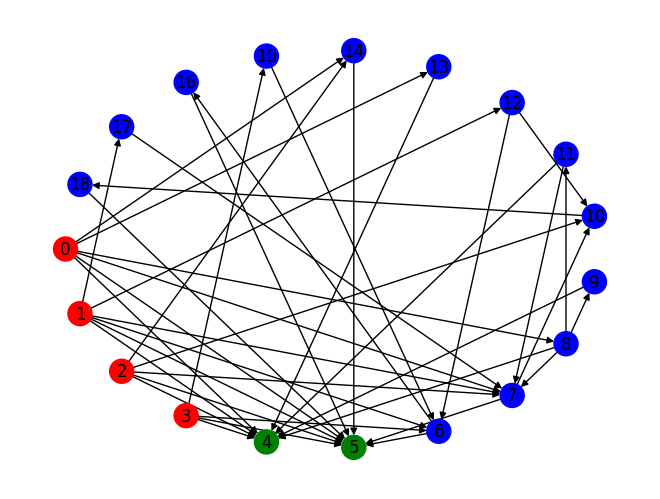

In [51]:
# Load the genome from the population
genome = Util.load_agent("./model/cartpole_example1") # use "./model/cartpole_example" for example agent
genome.visualize(with_colors=True)

In [52]:
# Example of how to evaluate the genome / agent on the cartpole environment
rewards = Util.eval_agent("CartPole-v1", genome, max_episodes=50, max_episode_length=500, render_intervall=20)

Generation 0, Reward: 500.0
Generation 1, Reward: 500.0
Generation 2, Reward: 500.0
Generation 3, Reward: 500.0
Generation 4, Reward: 500.0
Generation 5, Reward: 500.0
Generation 6, Reward: 500.0
Generation 7, Reward: 500.0
Generation 8, Reward: 500.0
Generation 9, Reward: 500.0
Generation 10, Reward: 500.0
Generation 11, Reward: 500.0
Generation 12, Reward: 500.0
Generation 13, Reward: 500.0
Generation 14, Reward: 500.0
Generation 15, Reward: 500.0
Generation 16, Reward: 500.0
Generation 17, Reward: 500.0
Generation 18, Reward: 500.0
Generation 19, Reward: 500.0
Generation 20, Reward: 500.0
Generation 21, Reward: 500.0
Generation 22, Reward: 500.0
Generation 23, Reward: 500.0
Generation 24, Reward: 500.0
Generation 25, Reward: 500.0
Generation 26, Reward: 500.0
Generation 27, Reward: 500.0
Generation 28, Reward: 500.0
Generation 29, Reward: 500.0
Generation 30, Reward: 500.0
Generation 31, Reward: 500.0
Generation 32, Reward: 500.0
Generation 33, Reward: 500.0
Generation 34, Reward: 5

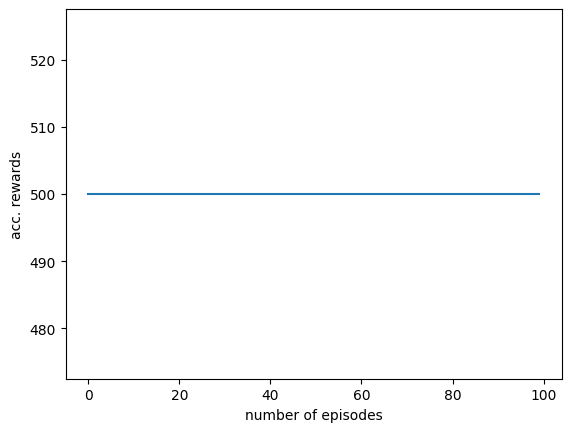

Mean Rewards over 100 episodes: 500.0


: 

In [55]:
# Plot the rewards of the model
Util.plot_curve(rewards, "number of episodes", "acc. rewards")
print(f"Mean Rewards over 100 episodes: {np.mean(rewards)}")

## EA Loop - Lunar Lander Environment
In this example we train a model for the Lunar Lander environment.

In [6]:
# Example of training an agent on the cartpole environment (Training takes much time!!!)
population, rewards = Util.train_agent("LunarLander-v2", max_episodes=100, max_episode_length=1000, n_episodes=5, n_genomes=20, n_parents=10, cfg_path="./config/lunar_lander", intermediate_path="./train/lunar_landar", initial_genome=genome)

Generation 0, Reward of the best model: 245.91901332792918
Generation 1, Reward of the best model: 205.24331185619567
Generation 2, Reward of the best model: 207.87401589530245
Generation 3, Reward of the best model: 172.73806958050443
Generation 4, Reward of the best model: 208.96569174044643
Generation 5, Reward of the best model: 238.2633488218775
Generation 6, Reward of the best model: 180.0319808505887
Generation 7, Reward of the best model: 171.82664680943927
Generation 8, Reward of the best model: 192.59696858979817
Generation 9, Reward of the best model: 162.007871793412
Generation 10, Reward of the best model: 180.20279078599606
Generation 11, Reward of the best model: 143.49464757589527
Generation 12, Reward of the best model: 142.46348860673191
Generation 13, Reward of the best model: 139.39865871282387
Generation 14, Reward of the best model: 239.73117608245235
Generation 15, Reward of the best model: 149.1921501755287
Generation 16, Reward of the best model: 149.6059815833

KeyboardInterrupt: 

In [49]:
# Get the best genome from the population
genome = population.get_best_genome()
print(genome.fitness)
print(population.population)

500.0
[Genome(id=885, #nodes=21, #connections=46, fitness=143.42857142857142), Genome(id=886, #nodes=19, #connections=42, fitness=500.0), Genome(id=887, #nodes=21, #connections=47, fitness=500.0), Genome(id=888, #nodes=18, #connections=40, fitness=59.714285714285715), Genome(id=889, #nodes=19, #connections=43, fitness=500.0), Genome(id=890, #nodes=18, #connections=40, fitness=500.0), Genome(id=891, #nodes=18, #connections=41, fitness=11.285714285714286), Genome(id=892, #nodes=21, #connections=47, fitness=45.0), Genome(id=893, #nodes=17, #connections=39, fitness=500.0), Genome(id=894, #nodes=20, #connections=44, fitness=500.0), Genome(id=895, #nodes=18, #connections=42, fitness=362.85714285714283), Genome(id=896, #nodes=19, #connections=43, fitness=102.57142857142857), Genome(id=897, #nodes=17, #connections=39, fitness=332.0), Genome(id=898, #nodes=19, #connections=42, fitness=190.85714285714286), Genome(id=899, #nodes=18, #connections=41, fitness=500.0), Genome(id=900, #nodes=19, #conn

In [12]:
# Safe the best genome from the population
genome = population.get_best_genome()
Util.save_agent(genome, "./model/lunar_lander_example1")

===== Nodes: =====
Node 0
Sensor
Bias: -0.01346397360350851
Node 1
Sensor
Bias: -0.028883829547329543
Node 2
Sensor
Bias: 0.017717500970126504
Node 3
Sensor
Bias: -0.023363839403140085
Node 4
Sensor
Bias: -0.058272682324681385
Node 5
Sensor
Bias: 0.0843859900534989
Node 6
Sensor
Bias: -0.02913180089092945
Node 7
Sensor
Bias: 0.0032931672939802386
Node 8
Output
Bias: -0.014944894496036804
Node 9
Output
Bias: 0.012551740615272212
Node 10
Output
Bias: -0.009500637561041761
Node 11
Output
Bias: -0.06890062818044555
Node 12
Hidden
Bias: 0.669909662329451
Node 13
Hidden
Bias: -0.45714037076034736
Node 14
Hidden
Bias: -0.9297534971183007
Node 15
Hidden
Bias: -0.3663084677162973
Node 16
Hidden
Bias: -0.33959182906058516
Node 17
Hidden
Bias: -0.14072286041362983
Node 18
Hidden
Bias: -0.32313199975779955
Node 19
Hidden
Bias: -0.14098258464887792
Node 20
Hidden
Bias: -0.0352291258044581
Node 21
Hidden
Bias: 0.25069068948934015
Node 22
Hidden
Bias: -0.08494498672918784
Node 23
Hidden
Bias: -0.1298

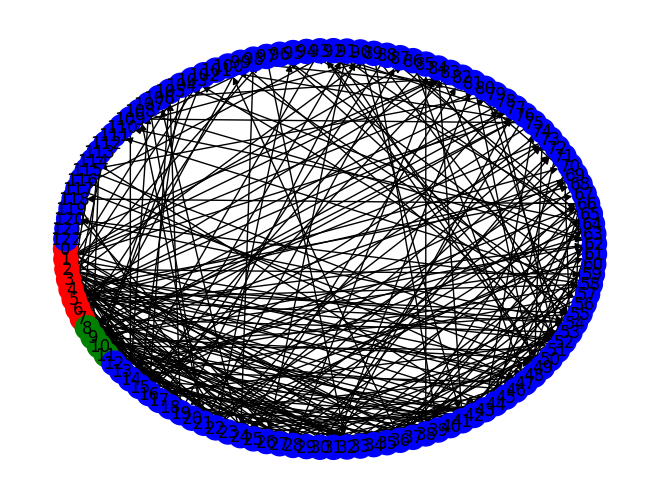

In [13]:
# Load the genome from the population
genome = Util.load_agent("./model/lunar_lander_example") # use "./model/lunar_lander_example" for example environment
genome.visualize(with_colors=True)
print(genome)

In [14]:
# Example to evaluate a model on a gym environment
rewards = Util.eval_agent("LunarLander-v2", genome, max_episodes=100, max_episode_length=1000, render_intervall=10)

Generation 0, Reward: -13.107787086474687
Generation 1, Reward: 84.9583047875174
Generation 2, Reward: 209.3614063720707
Generation 3, Reward: 3.9805417564347323
Generation 4, Reward: 11.038913812275709
Generation 5, Reward: 250.22321022135532
Generation 6, Reward: 230.07459496297977
Generation 7, Reward: 270.51694344915836
Generation 8, Reward: -6.937058034561645
Generation 9, Reward: 249.44347822567468
Generation 10, Reward: -80.06187273750474
Generation 11, Reward: 204.87369878317327
Generation 12, Reward: 101.71941272455727
Generation 13, Reward: -7.69896057899949
Generation 14, Reward: 280.18712483777915
Generation 15, Reward: 249.1907543210239
Generation 16, Reward: 197.34410757302015
Generation 17, Reward: 197.21137547353953
Generation 18, Reward: 196.55495542179898
Generation 19, Reward: 140.828657269916
Generation 20, Reward: 13.457023862249244
Generation 21, Reward: 230.75189738212057
Generation 22, Reward: 112.24243840204593
Generation 23, Reward: 17.122800716672742
Generati

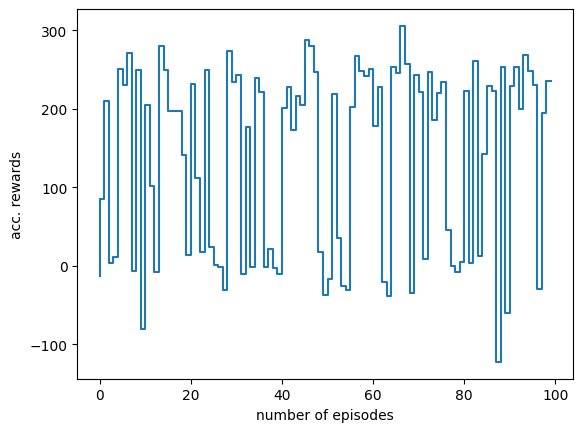

Mean Rewards over 100 episodes: 137.28722839451305


In [15]:
# Plot the rewards of the model
Util.plot_curve(rewards, "number of episodes", "acc. rewards")
print(f"Mean Rewards over 100 episodes: {np.mean(rewards)}")